# Proteins functions prediction project

This scripts explore the Uniprot and GO ontology datasets. It is used for the proteins function prediction project. The output of the script is a yaml file containing the criterias to use to filter out the examples from the dataset and to filter out the GO terms.

The yaml file contains information about the amino acids sequences length, the GO terms to use as labels and the mapping of GO sub-terms to GO labels. 

In [2]:
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml
sns.set()

# Amino acids sequences analysis

In [3]:
with open('../../hyperparams.yaml') as f:
    configs=yaml.load(f)
    
data_dir=configs['data_dir']
with open(data_dir+"proteins_goes", "rb") as fp:
    proteins_goes=pickle.load(fp)

with open(data_dir+"proteins_seqs", "rb") as fp:
    proteins_seqs=pickle.load(fp)

In [4]:
print('Number of examples\'s labels:', len(proteins_goes))
print('Number of examples\'s sequences:', len(proteins_seqs))

print('\nFirst sequence:\n'+proteins_seqs[0])
print('\nGO terms of first sequence:\n'+str(proteins_goes[0]))

Number of examples's labels: 1500
Number of examples's sequences: 1500

First sequence:
ADTIVAVELDTYPNTDIGDPSYPHIGIDIKSVRSKKTAKWNMQNGKVGTAHIIYNSVGKRLSAVVSYPNGDSATVSYDVDLDNVLPEWVRVGLSATTGLYKETNTILSWSFTSKLKSNSTHETNALHFMFNQFSKDQKDLILQGDATTGRDGNLELTRVSSNGSPQGSSVGRALFYAPVHIWESSAVVASFDATFTFLIKSSDSHPADGIAFFISNIDSSIPSGSTGRLLGLFPDAN

GO terms of first sequence:
['GO:0005537', 'GO:0046872']


# AA sequences

Let's start with parsing the amino acid sequences to answer the following questions:

-How many unique amino acids there are in the database?

-How many times each amino acid appear?

-How long the amino acid sequences are?

In [5]:
count_aminos={}
length_seqs=[]
for i, seq in enumerate(proteins_seqs):
    length_seqs.append(len(seq))
    for a in seq:
        if a in count_aminos:
            count_aminos[a] += 1
        else:
            count_aminos[a] = 0

Unique aminos (21):
['A', 'D', 'T', 'I', 'V', 'E', 'L', 'Y', 'P', 'N', 'G', 'S', 'H', 'K', 'R', 'W', 'M', 'Q', 'F', 'C', 'X']


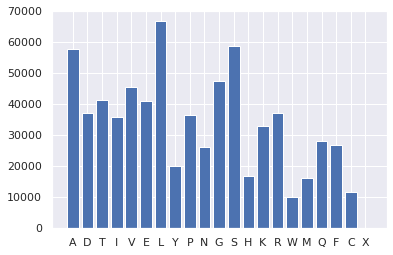

In [6]:
unique_aminos=list(count_aminos.keys())

print('Unique aminos ({}):\n{}'.format(len(unique_aminos), unique_aminos))
x=[i for i in range(len(unique_aminos))]
plt.bar(x, count_aminos.values())
plt.xticks(x, unique_aminos)
plt.show()

There are 25 unique amino acids. The first 20 are the 20 known amino acids which appear from only 2.5 million times such as Tryptophan(W) and Cysteine(C) to around 20 million times such as Alanine(A) and Leucine(L).

Interestingly, the last 5 amino acids: U, X, B, Z and O which appear 

In [7]:
print(list(count_aminos.values())[-5:])

[16056, 28076, 26791, 11542, 5]


They describe respectively:

U:

X: any amino acid

B: Asparagine/Aspartic Acid

Z: Glutamine/Glutamic Acid

O: 

As far as concerns the sequences

In [8]:
print('Average length:', np.mean(length_seqs))
print('Deviation:', np.std(length_seqs))
print('Min length:', np.min(length_seqs))
print('Max length:', np.max(length_seqs))

Average length: 462.3586666666667
Deviation: 724.145045801062
Min length: 12
Max length: 11872


In [9]:
sorted_seqs=np.array(length_seqs)
sorted_seqs.sort()
print('10 shortest:\n{}\n10 longest:\n{}'.format(sorted_seqs[:10], sorted_seqs[-10:]))
print('Number sequences less than 30 AA:', len(sorted_seqs[sorted_seqs<30]))
print('Number sequences more than 500 AA:', len(sorted_seqs[sorted_seqs>500]))
print('Number sequences more than 1000 AA:', len(sorted_seqs[sorted_seqs>1000]))

10 shortest:
[12 15 15 15 16 16 16 16 16 16]
10 longest:
[ 5061  5073  5082  5112  5161  5209  5400  5641  8903 11872]
Number sequences less than 30 AA: 27
Number sequences more than 500 AA: 389
Number sequences more than 1000 AA: 113


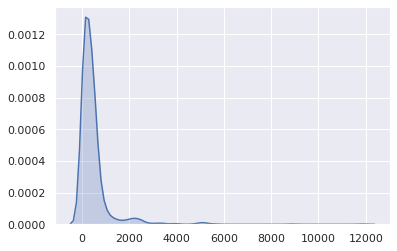

In [10]:
fig, ax=plt.subplots()

ax=sns.kdeplot(length_seqs, shade=True)

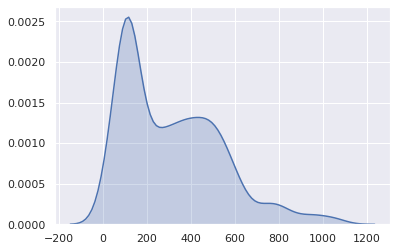

In [11]:
length_seqs=np.asarray(length_seqs)
lengths_truncated=length_seqs[length_seqs<(378+2*350)]


fig, ax=plt.subplots()

ax=sns.kdeplot(lengths_truncated, shade=True)

# GOs analysis

The list of known protein functions is build and curate by Gene Ontology Consortium. I'm going to use the go-basic.obo version.

In [12]:
import obonet
import networkx
graph=obonet.read_obo(data_dir+'go-basic.obo')
gos_classified=graph.nodes()
print('Number of GO terms classified by ontology:', len(gos_classified))

Number of GO terms classified by ontology: 44945


Let's start by exploring the GO terms in the examples. Some question to answer:
- How many unique GO terms there are in the dataset?
- How many examples there are for each GO term?

In [13]:
#GOs in dataset
dataset_gos={}
num_gos_examples=[]

for seq_goes in proteins_goes:
    num_gos_examples.append(len(seq_goes))
    for go in seq_goes:
        if go in dataset_gos:
            dataset_gos[go] +=1
        else:
            dataset_gos[go] = 1

unique_gos=np.asarray(list(dataset_gos.keys()))
gos_num_occurences=np.asarray(list(dataset_gos.values()))
print('Number of unique GOs in the dataset:', len(unique_gos))
print('Minimum times go occurs:', np.min(gos_num_occurences))
print('Maximum times go occurs:', np.max(gos_num_occurences))
print('Average:', np.mean(gos_num_occurences))

Number of unique GOs in the dataset: 1582
Minimum times go occurs: 1
Maximum times go occurs: 307
Average: 3.6308470290771178


In [15]:
gos_asc_order_occurence=unique_gos[np.argsort(gos_num_occurences)]
print('>Top 5 least frequent terms:')
for idx, term in enumerate(gos_asc_order_occurence[:10]):
    print('{} | {} | frequency: {}'.format(term, graph.nodes()[term]['name'], gos_num_occurences[np.argsort(gos_num_occurences)][idx]))

print('\n>Top 5 top frequent terms:')
for idx, term in enumerate(gos_asc_order_occurence[-10:]):
    print('{} | {} | frequency: {}'.format(term, graph.nodes()[term]['name'], gos_num_occurences[np.argsort(gos_num_occurences)][-(10-idx)]))

>Top 5 least frequent terms:
GO:1904644 | cellular response to curcumin | frequency: 1
GO:0097110 | scaffold protein binding | frequency: 1
GO:0030971 | receptor tyrosine kinase binding | frequency: 1
GO:0005080 | protein kinase C binding | frequency: 1
GO:0019901 | protein kinase binding | frequency: 1
GO:0004709 | MAP kinase kinase kinase activity | frequency: 1
GO:0030115 | S-layer | frequency: 1
GO:0050727 | regulation of inflammatory response | frequency: 1
GO:0071399 | cellular response to linoleic acid | frequency: 1
GO:0070540 | stearic acid binding | frequency: 1

>Top 5 top frequent terms:
GO:0009405 | pathogenesis | frequency: 79
GO:0016491 | oxidoreductase activity | frequency: 84
GO:0042101 | T cell receptor complex | frequency: 89
GO:0005634 | nucleus | frequency: 103
GO:0046872 | metal ion binding | frequency: 109
GO:0090729 | toxin activity | frequency: 115
GO:0002250 | adaptive immune response | frequency: 127
GO:0005886 | plasma membrane | frequency: 149
GO:0005576 | 

In [16]:
num_dataset_gos_classified=0
num_dataset_gos_not_classified=0
for go_name in dataset_gos:
    if go_name in gos_classified:
        num_dataset_gos_classified +=1
    else:
        num_dataset_gos_not_classified +=1

print('Number of GOs available in the GO ontology:', num_dataset_gos_classified)
print('NOT available in the GO onology dictionary:', num_dataset_gos_not_classified)

Number of GOs available in the GO ontology: 1582
NOT available in the GO onology dictionary: 0


From this first quick analysis we can see that there are 44945 listed in the GO Ontology file. While the GO used to describe the proteins functions are 28182. Morever, of these 28182 GO terms, 54 are not listed in the GO ontology file.

Predicting 44945 labels is a huge multi-label classification problem. Due to the fact that the GO terms are stored in an Acyclic Graph, there are functions which describe multiple sub-functions. So, the number of functions to predict can be reduced by limiting the depth/precision of the predicted function. 

Let's parse the GO graph and split the GO terms based on their depth in the graph. The depth indicates the specificity of the function. For example, a GO term at depth 3 describes a specific function which belongs to a broader function described by a GO term at depth 2 or 1. 

## Split GOs in levels

In [17]:
go_classes={
    'biological_process':'GO:0008150',
    'molecular_function':'GO:0003674',
    'cellular_component':'GO:0005575'
}

In [18]:
report_depths={}
for go_id in graph.nodes():
    node=graph.nodes()[go_id]
    #retrieve target node_id for the path
    go_class_id=go_classes[node['namespace']]
    
    paths = networkx.all_simple_paths(
        graph,
        source=go_id,
        target=go_class_id
    )
    
    #retrieve the longest path (depth)
    paths_length=[len(path) for path in paths]
    if (paths_length==[]):
        print(go_id)
        depth=0
    else:
        depth=max(paths_length)-1
    #save the go_id and its depth
    if (depth not in report_depths):
        report_depths[depth]=[go_id]
    else:
        report_depths[depth].append(go_id)


GO:0003674
GO:0005575
GO:0008150


In [19]:
for depth in report_depths:
    print('Depth: {}, terms: {}'.format(depth, len(report_depths[depth])))

Depth: 6, terms: 5464
Depth: 5, terms: 7473
Depth: 1, terms: 61
Depth: 9, terms: 5020
Depth: 4, terms: 2899
Depth: 8, terms: 5049
Depth: 7, terms: 5501
Depth: 3, terms: 1387
Depth: 2, terms: 467
Depth: 12, terms: 2012
Depth: 13, terms: 1226
Depth: 11, terms: 3094
Depth: 10, terms: 4102
Depth: 14, terms: 659
Depth: 15, terms: 339
Depth: 16, terms: 137
Depth: 0, terms: 3
Depth: 17, terms: 40
Depth: 18, terms: 10
Depth: 19, terms: 2


## Generating labels

Let's start with prediting the first 3 levels. Here how many GO terms there are for each GO class for the first 3 levels

In [20]:
max_depth=3

In [21]:
labels=[]

go_classes_count={
    'biological_process':0,
    'molecular_function':0,
    'cellular_component':0
}


for depth in range(max_depth+1):
    for go in report_depths[depth]:
        labels.append(go)
        
for go in labels:
    go_classes_count[graph.nodes()[go]['namespace']] +=1
    
print('Number of labels:', len(labels))
print('GO classes:',go_classes_count)
        

Number of labels: 1918
GO classes: {'biological_process': 759, 'molecular_function': 716, 'cellular_component': 443}


The model is going to predict a total of 1918 GO terms. At the moment, all the terms of level 4 up to level 19 are grouped into their higher level terms. If a term of level 4 or more belongs to two or more labels, both labels are going to be set as 1.

However, an AA sequence is not associated with all the GO terms at different levels. So, for each GO term, label or not, all the parent nodes available as label are associated to the GO term.

In [26]:
#Map each GO term to its parent nodes selected as labels.
parent_terms={}
for idx, go_id in enumerate(graph.nodes()):
    if idx%5000==0:
        print('Processed: {} terms'.format(idx))
    node=graph.nodes()[go_id]
    #retrieve target node_id for the path
    go_class_id=go_classes[node['namespace']]

    paths = networkx.all_simple_paths(
        graph,
        source=go_id,
        target=go_class_id
    )
    if (go_id in labels):
        parents=[go_id] #include itself
    else:
        parents=[]
    for path in paths:
        for term in path:
            if ((term in labels) and (term not in parents)):
                parents.append(term)

    parent_terms[go_id]=parents
                                
print(len(parent_terms))

Processed: 0 terms
Processed: 5000 terms
Processed: 10000 terms
Processed: 15000 terms
Processed: 20000 terms
Processed: 25000 terms
Processed: 30000 terms
Processed: 35000 terms
Processed: 40000 terms
44945


Finally, let's see how many times the labels occurs in the dataset as well as how many labels each example has. First without subterms integration

In [23]:
labels_counter={}
examples_labels_counter=[]
#build labels counter
for go in labels:
    labels_counter[go]=0
    
for idx, seq_goes in enumerate(proteins_goes):
    labels_example=[]
    for go in seq_goes:
        #for each GO in each example
        if go in labels:
            labels_counter[go] += 1
            if go not in labels_example:
                labels_example.append(go)
            
    examples_labels_counter.append(labels_example)

n_labels=list(labels_counter.values())
examples_counter=[len(ex) for ex in examples_labels_counter]

print('Label that appears the least number of times', min(n_labels))
print('Label that appears the most number of times', max(n_labels))
print('Average number of times that labels occur', np.mean(n_labels))
print('Number of labels that has no examples', len(n_labels)-np.count_nonzero(n_labels))
print('\n\n')
print('Higher number of labels for a single example', max(examples_counter))
print('Lower number of labels for a single example', min(examples_counter))
print('Average number of labels for a single example', np.mean(examples_counter))
print('Number of examples with no labels', len(examples_counter)-np.count_nonzero(examples_counter))

Label that appears the least number of times 0
Label that appears the most number of times 200
Average number of times that labels occur 0.8096976016684045
Number of labels that has no examples 1747



Higher number of labels for a single example 8
Lower number of labels for a single example 0
Average number of labels for a single example 1.0353333333333334
Number of examples with no labels 579


Then, integrating the subterms

In [24]:
labels_counter={}
examples_labels=[]
#build labels counter
for go in labels:
    labels_counter[go]=0
    
for idx, seq_goes in enumerate(proteins_goes):
    labels_example=[]
    for go in seq_goes:
        #get all the labels associate with a GO term
        go_parents=parent_terms[go]
        for go_p in go_parents:
            if ((go_p in labels) and (go_p not in labels_example)):
                labels_counter[go_p] +=1
                labels_example.append(go_p)
    
    examples_labels.append(labels_example)
            
n_labels=list(labels_counter.values())
examples_counter=[len(ex) for ex in examples_labels]

print('Label that appears the least number of times', min(n_labels))
print('Label that appears the most number of times', max(n_labels))
print('Average number of times that labels occur', np.mean(n_labels))
print('Number of labels that has no examples', len(n_labels)-np.count_nonzero(n_labels))
print('\n\n')
print('Higher number of labels for a single example', max(examples_counter))
print('Lower number of labels for a single example', min(examples_counter))
print('Average number of labels for a single example', np.mean(examples_counter))
print('Number of examples with no labels', len(examples_counter)-np.count_nonzero(examples_counter))

Label that appears the least number of times 0
Label that appears the most number of times 959
Average number of times that labels occur 12.509384775808133
Number of labels that has no examples 1333



Higher number of labels for a single example 174
Lower number of labels for a single example 0
Average number of labels for a single example 15.995333333333333
Number of examples with no labels 112


# Conclusion

Now, that I got an idea of the dataset, I have to decide the criterias in order to remove the examples that don't match all the requirements.

There is a total of 560118 sequences with a length ranging from 2 to 35k amino acids. Around 5k proteins are below 30 amino acids which is common to be the minimum length required to define an amino acid sequence as protein. Other 18k proteins have a length larger than 1000 amino acids.
Moreover, some sequences have unknown amino acids marked as X.

The GOs provided by the Gene Ontology Consortium are 44945 while the GO terms used by the examples are only 28182. Moreover, 54 functions carried by some proteins in the database are not available in the GO ontology dictionary. 

I decided to start by using amino acids sequences between 0 and 512 long. There is no particular reason behind this numbers. 

The 44945 possible labels create a very hard multi-label classification problem with a very sparse output vector. So, I decided to limit the predictions to the 1918 more general functions which correspond to the GO terms up to depth 3 in the acyclic graph of GO terms. 
The GO terms not in the GO dictonary (acyclic graph) are discarded while the other 40000 and more terms which are available in the acyclic graph are handled as follows.

The remaining 40000 and more terms are sub-terms of the 1918 functions used as labels. So, I decided to substitute these sub-terms with their parent functions available as labels. In the case that an example has a sub-term belonging to two or more GO labels, all these GO labels are used as prediction.

This choice allows to move from an average of 0.6 labels for example to almost 25 labels reducing the sparsity. At the same time, it allows to move from 327438 examples with 0 labels as predictions to only 25914. 
Moreover, now only 365 functions of the 1918 available have no examples. 


**IDEAS:**

- Maybe use amino acid sequences between 0 and 1025 (2 stds from the mean which covers 97.7% of the examples in the dataset) or between 0 and 692 (1 std from the mean, which is 84.1% of dataset). Decide based on the memory contraints due to the input of size \[batch, seq_length, amino_acid_vec\] 
- Consider to increase the depth of the functions used as prediction
- Consider to use a GO ontology dictionary that contains more relationship than only is_a in order to better capture the relationships between the different functions

In [27]:
data={}
data['unique_aminos']=unique_aminos
data['available_gos']=labels
data['mapped_gos']=parent_terms

with open(data_dir+'dataset_config.yaml', 'w') as outfile:
    yaml.dump(data, outfile)